In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/MyDrive/Colab Notebooks/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/Colab Notebooks/storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [5]:
df_final_train.shape

(100002, 54)

# Reading File

In [7]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    #print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")
    
print("\nTime taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2023-02-02 17:18:57.070054

Time taken for creation of dataframe is 0:01:24.235386


<h1>Adding new feature Preferential Attachment</h1>
One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

In [8]:
# source : https://medium.com/@cynosuremishra01/different-featurization-techniques-for-graph-related-problems-in-machine-learning-9c9d60caae60
def prefrential_attachment_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
        return sim
    except:
        return 0
    
def prefrential_attachment_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))
        return sim
    except:
        return 0

In [9]:
df_final_train['prefrential_attachment_followees'] = df_final_train.apply(lambda row : prefrential_attachment_followees(row['source_node'], row['destination_node']), axis = 1)
df_final_train['prefrential_attachment_followers'] = df_final_train.apply(lambda row : prefrential_attachment_followers(row['source_node'], row['destination_node']), axis = 1)

In [10]:
df_final_test['prefrential_attachment_followees'] = df_final_test.apply(lambda row : prefrential_attachment_followees(row['source_node'], row['destination_node']), axis = 1)
df_final_test['prefrential_attachment_followers'] = df_final_test.apply(lambda row : prefrential_attachment_followers(row['source_node'], row['destination_node']), axis = 1)

In [11]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefrential_attachment_followees', 'prefrential_attachment_followers'],
      dtype='object')

In [12]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefrential_attachment_followees,prefrential_attachment_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,66
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,1598
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,980


## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [13]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = {val : idx for idx, val in enumerate(sadj_col)}

In [14]:
def svd(x, U):
    try:
        z = sadj_dict[x]
        return U[z]
    except:
        return [0, 0, 0, 0, 0, 0]

In [15]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
Adj = nx.adjacency_matrix(train_graph, nodelist = sadj_col).asfptype() #!pip install 'networkx<2.7'

In [17]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape', Adj.shape)
print('U Shape', U.shape)
print('V Shape', V.shape)
print('s Shape', s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [20]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================


In [21]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefrential_attachment_followees', 'prefrential_attachment_followers'],
      dtype='object')

#Adding feature svd_dot

In [28]:
train_svd_s = df_final_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]
train_svd_d = df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]

In [29]:
svd_dot_train = []
for i in range(len(train_svd_s)):
    svd_dot_train.append(sum(train_svd_s.values[i]*train_svd_d.values[i]))

In [30]:
df_final_train['svd_dot'] = svd_dot_train

In [31]:
test_svd_s = df_final_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]
test_svd_d = df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]

In [32]:
svd_dot_test = []
for i in range(len(test_svd_s)):
    svd_dot_test.append(sum(test_svd_s.values[i]*test_svd_d.values[i]))

In [33]:
df_final_test['svd_dot'] = svd_dot_test

In [35]:
df_final_train.shape

(100002, 57)

In [36]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [51]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# XGBoost

In [52]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [53]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist, return_train_score=True,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)


RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f44ccfa1f40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f44cde20d90>},
                   random_state=25, return_train_score=True, scoring='f1')

In [54]:
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

mean test scores [0.97977244 0.97989649 0.97978088 0.97974484 0.97977424]
mean train scores [0.99999001 0.99999001 0.99369785 0.99696977 0.99720576]


In [55]:
print(model.best_estimator_)

XGBClassifier(max_depth=14, n_estimators=123)


In [56]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [57]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [58]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9909506352633959
Test f1 score 0.9277220995413622


In [59]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


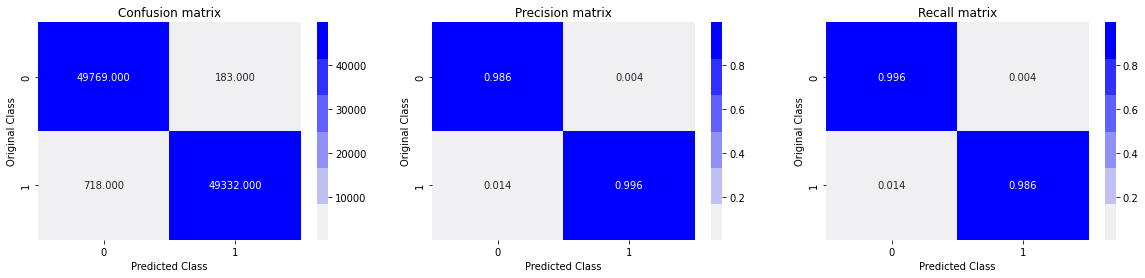

Test confusion_matrix


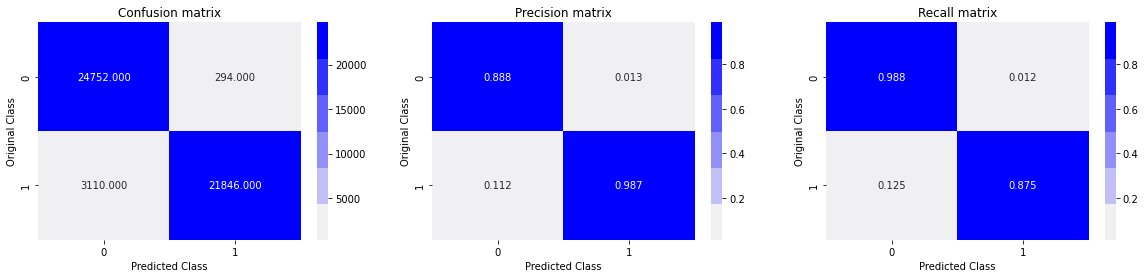

In [60]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

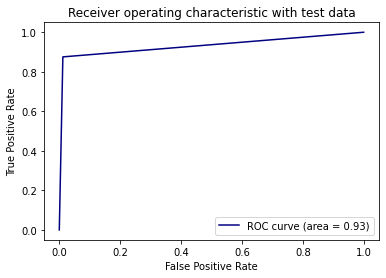

In [61]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

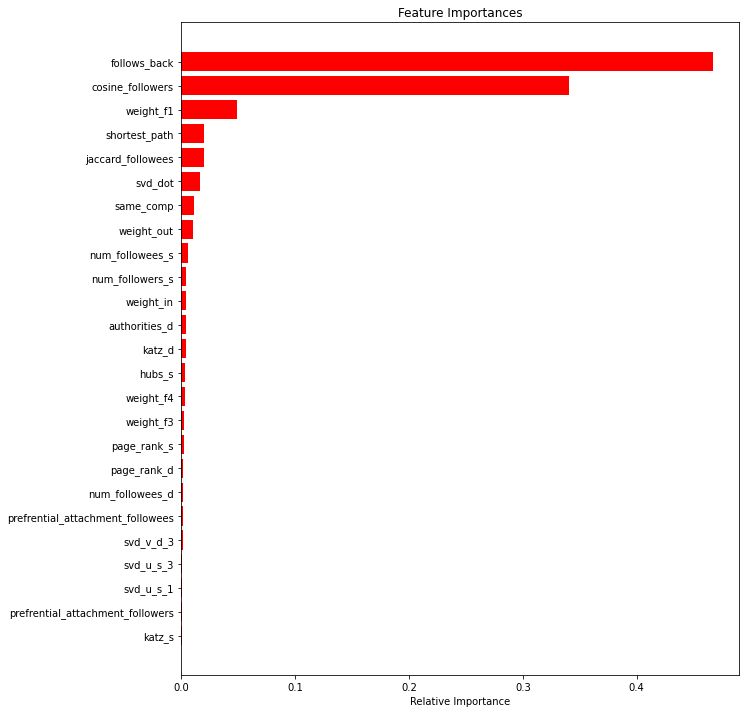

In [62]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [65]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
# Forest','121','14','0.964','0.921'])
x.add_row(['XGBOOST','123','14',' 0.9909','0.9277'])
print(x)

+---------+--------------+-----------+----------------+---------------+
|  Model  | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------+--------------+-----------+----------------+---------------+
| XGBOOST |     123      |     14    |     0.9909     |     0.9277    |
+---------+--------------+-----------+----------------+---------------+


# Observation
1. First we added preferntial attechment with followers and followees data of vertex feature to our dataset.
2. Then added svd_dot feature fro train and test dataset.
3. In last we done hyperparameter tuning with XG Boost with all these features and check the error metric.
4. After doing Feature Engineering we observe that follow back and cosine followers is the important feature among others.
5. In last we plotted confusion matrix and pretty-table for both algorithm and found best hyperparameters.